In [1]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import random
import math
import time

import numpy as np
np.random.seed(1)
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.utils import np_utils
from keras.optimizers import SGD
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
#%matplotlib notebook

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

from numpy.linalg import inv
from numpy import linalg as LA
from scipy import linalg
import random

from matplotlib import animation, rc
from IPython.display import HTML

Using TensorFlow backend.


In [12]:
def prepare_training_data(df_F, df_D, df_Dt, d):
    
    DF = []
    for i in range(d):
        if i == 0:
            DF = np.concatenate((df_F.shift(d-i).values, df_D.shift(d-i).values, df_Dt.shift(d-i).values), axis = 1)
        else:
            DF = np.concatenate((DF, df_F.shift(d-i).values, df_D.shift(d-i).values, df_Dt.shift(d-i).values), axis=1)

    DF = DF[d:,:]
    Dy = np.concatenate((df_D.values, df_Dt.values), axis=1)
    Dy = Dy[d:,:]
    
    return DF, Dy

In [28]:
def train_test_split(DF, Dy, d, x_scaler, y_scaler):

    dim = np.shape(Dy)

    n_nodes = int(dim[1]/2)
    n_y = dim[1]
    x = np.linspace(0,1, n_nodes)

    #Scaling
    DFscaled = x_scaler.transform(DF)
    Dyscaled = y_scaler.transform(Dy)

    X_train = DFscaled
    Y_train = Dyscaled

    #Train test split
    train_portion = 0.8
    n_timesteps = len(X_train[:,0])
    x_train = X_train[0:int(n_timesteps*train_portion),:]
    x_test = X_train[int(n_timesteps*(train_portion)):,:]
    y_train = Y_train[0:int(n_timesteps*train_portion),:]
    y_test = Y_train[int(n_timesteps*(train_portion)):,:]

    n_features = int(x_train.shape[1]/d)
    x_train = x_train.reshape((x_train.shape[0], d, n_features))
    x_test = x_test.reshape((x_test.shape[0], d, n_features))

    return x_train, x_test, y_train, y_test, n_nodes, n_features, n_y, x

In [65]:
def initialize_model(n_units, x_train, y_train):
    model = Sequential()
    model.add(LSTM(n_units, input_shape=(x_train.shape[1], x_train.shape[2]),))
    model.add(Dense(len(y_train[0,:])))
    adam = Adam(lr=0.001)
    model.compile(loss='mae', optimizer=adam)
    
    earlystop = EarlyStopping(monitor='loss', min_delta=0.0001, patience=5, verbose=1, mode='auto')
    callback_list = [earlystop]
    return model, callback_list

In [5]:
def get_error(predictions, y_test):
    error = 0
    for i in range(len(predictions[:,0])):
        error += np.trapz((y_test[i,:] - predictions[i,:])**2, x)
    return error

In [25]:
def independent_predictions(x_test):

    input_i = np.copy(x_test[0,:,:])
    input_i_reshaped = input_i.reshape((1,d,n_features))

    #input_dim = x_test[0,:,:].shape

    future_timesteps = len(x_test[:,0,0])-1
    preds = np.zeros([future_timesteps, n_y])

    force = np.copy(x_test[:,:,:(n_nodes)])
    #model.reset_states()
    for i in range(future_timesteps): 
        pred = model.predict(input_i_reshaped)
        preds[i, :] = pred[0]

        input_i[0:d-1,:] = input_i[1:d,:]
        input_i[d-1,:n_nodes] = force[i+1,d-1,:]
        input_i[d-1,n_nodes:] = pred[0]

        input_i_reshaped = input_i.reshape((1,d,n_features))
        
    return preds

In [16]:
def get_scalers(DF, Dy):
    
    x_scaler = MinMaxScaler()
    y_scaler = MinMaxScaler()
    
    x_scaler.fit_transform(DF)
    y_scaler.fit_transform(Dy)
    
    return x_scaler, y_scaler

In [17]:
def get_batch_scalers(n_batches):
    
    #Simple version
    for i in range(n_batches):
        
        df_D = pd.read_csv('C:/Users/endrep/Documents/training_batches/D' + str(i+1) + '.csv')
        df_F = pd.read_csv('C:/Users/endrep/Documents/training_batches/F' + str(i+1) + '.csv')
        df_Dt = pd.read_csv('C:/Users/endrep/Documents/training_batches/Dt' + str(i+1) + '.csv')
        
        
        if i == 0:  
            x_range = df_D.values.max() - df_D.values.min()
            imax = i
        
        else:
            new_x_range = df_D.values.max() - df_D.values.min()
            
            if new_x_range > x_range:
                x_range = new_x_range
                imax = i
                
    df_D = pd.read_csv('C:/Users/endrep/Documents/training_batches/D' + str(imax+1) + '.csv')
    df_F = pd.read_csv('C:/Users/endrep/Documents/training_batches/F' + str(imax+1) + '.csv')
    df_Dt = pd.read_csv('C:/Users/endrep/Documents/training_batches/Dt' + str(i+1) + '.csv')
    
    DF, Dy = prepare_training_data(df_F, df_D, df_Dt, d)
    x_scaler, y_scaler = get_scalers(DF, Dy)
    
    return x_scaler, y_scaler

In [66]:
######################### BATCH TRAINING ########################################

n_batches = 1
d = 50

t0 = time.time()

x_scaler, y_scaler = get_batch_scalers(n_batches)

for i in range(n_batches):

    df_D = pd.read_csv('C:/Users/endrep/Documents/training_batches/D' + str(i+1) + '.csv')
    df_F = pd.read_csv('C:/Users/endrep/Documents/training_batches/F' + str(i+1) + '.csv')
    df_Dt = pd.read_csv('C:/Users/endrep/Documents/training_batches/Dt' + str(i+1) + '.csv')

    DF, Dy = prepare_training_data(df_F, df_D, df_Dt, d)
    
    #if i == 0:
    #    x_scaler, y_scaler = get_scalers(DF, Dy)
    
    x_train, x_test, y_train, y_test, n_nodes, n_features, n_y, x = train_test_split(DF, Dy, d, x_scaler, y_scaler)
    
    ts = time.time()
    if i == 0:
        model, callback_list = initialize_model(500, x_train, y_train)
    
    #model.fit(x_train, y_train, epochs=100, callbacks=callback_list, batch_size=len(x_train), verbose=0, shuffle=False)
    model.fit(x_train, y_train, epochs=100, callbacks=None, batch_size=len(x_train), verbose=1, shuffle=False)
    
    training_time = time.time() - ts
    
    preds = model.predict(x_test)
    y_test_u = y_test
    
    independent_preds = independent_predictions(x_test)
    
    test_error = get_error(y_test_u[:,:n_nodes], preds[:,:n_nodes])
    independent_test_error = get_error(y_test_u[0:len(independent_preds[:,0]),:n_nodes], independent_preds[:,:n_nodes])
    
    total_time = time.time() - t0
    
    info = {'Iteration number': i+1, 'Test Error': test_error, 'Ind test error': independent_test_error,
            'Training time': training_time, 'Total time': total_time}
    print(info)

Epoch 1/100


KeyboardInterrupt: 

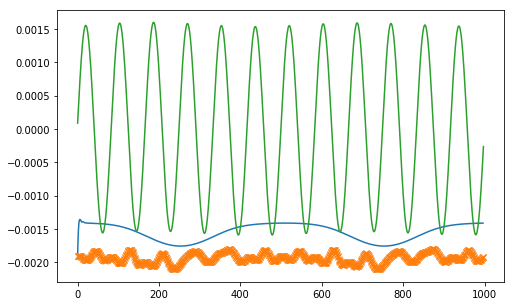

{'Iteration number': 1, 'Test Error': 407.56381856333417, 'Ind test error': 364.95304936947093, 'Training time': 0.0, 'Total time': 1.3987114429473877}


In [62]:
######################### BATCH TESTING ########################################

n_batches = 1
d = 10

t0 = time.time()
for i in range(n_batches):

    df_D = pd.read_csv('C:/Users/endrep/Documents/training_batches/D' + str(i+1) + '.csv')
    df_F = pd.read_csv('C:/Users/endrep/Documents/training_batches/F' + str(i+1) + '.csv')
    df_Dt = pd.read_csv('C:/Users/endrep/Documents/training_batches/Dt' + str(i+1) + '.csv')

    DF, Dy = prepare_training_data(df_F, df_D, df_Dt, d)
    
    #if i == 0:
    #    x_scaler, y_scaler = get_scalers(DF, Dy)
    
    x_train, x_test, y_train, y_test, n_nodes, n_features, n_y, x = train_test_split(DF, Dy, d, x_scaler, y_scaler)
    
    ts = time.time()
    #if i == 0:
    #    model, callback_list = initialize_model(100, x_train, y_train)
    
    #model.fit(x_train, y_train, epochs=100, callbacks=callback_list, batch_size=len(x_train), verbose=0, shuffle=False)
    
    training_time = time.time() - ts
    
    preds = model.predict(x_test)
    preds_u = y_scaler.inverse_transform(preds)
    y_test_u = y_scaler.inverse_transform(y_test)
    
    independent_preds = independent_predictions(x_test)
    
    independent_preds_u = y_scaler.inverse_transform(independent_preds)
    
    test_error = get_error(y_test[:,:n_nodes], preds[:,:n_nodes])
    independent_test_error = get_error(y_test[0:len(independent_preds[:,0]),:n_nodes], independent_preds[:,:n_nodes])
    
    plt.figure(figsize=(8,5))
    plt.plot(independent_preds_u[:,n_nodes-1])
    plt.plot(preds_u[:,n_nodes-1], 'x')
    plt.plot(y_test_u[:,n_nodes-1])
    plt.show()
    

    
    total_time = time.time() - t0
    
    info = {'Iteration number': i+1, 'Test Error': test_error, 'Ind test error': independent_test_error,
            'Training time': training_time, 'Total time': total_time}
    print(info)

In [40]:
#Export results
np.savetxt("predictions.csv", independent_preds_u, delimiter=",")
np.savetxt("preds.csv", preds_u, delimiter=",")
np.savetxt("y_test.csv", y_test_u, delimiter=",")
np.savetxt("y_train.csv", y_test_u, delimiter=",")

In [88]:
independent_preds_u.shape

(998, 21)

In [89]:
DF.shape

(4995, 205)

In [91]:
df_D.values.shape

(5000, 21)